<div style="color:#D81F26;
           display:fill;
           border-style: solid;
           border-color:#C1C1C1;
           font-size:25px;
           font-family:Calibri;
           background-color:#373737;">
<h2 style="text-align: center;
           padding: 10px;
           color:#FFFFFF;">
 Sentiment Analysis on McDonald's Reviews  Dataset
</h2>
</div>

# Table of Contents

1. [Problem Statement](#problem_statement)
2. [Import Libraries](#import_libraries)
3. [Data Cleaning](#data_cleaning)
4. [Train and Test Split](#train_test_split)
5. [Tokenizer and padding](#Tokenizer)
6. [LSTM Architecture](#LSTM)
7. [LSTM Model Summary](#Summary)
8. [Evaluate the LSTM model](#Evaluate)
9. [Model Testing](#Model_Testing)
10. [Conclusion](#conclusion)

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Problem Statement  <a id="problem_statement"></a> </p>

> The task involves sentiment analysis on customer reviews of a McDonald's restaurant using Natural Language Processing (NLP) techniques and a Long Short-Term Memory (LSTM) neural network model.

> The objective is to train a model that can classify customer sentiments as positive, negative, or neutral based on the textual content of their reviews. 

> The dataset includes reviews and corresponding ratings, with sentiment labels derived from the ratings. The challenges include preprocessing the text data, handling imbalanced classes, and training an effective LSTM model using pre-trained word embeddings. 

> The goal is to provide McDonald's with a tool that can automatically analyze and categorize customer sentiments to gain insights into their overall satisfaction and identify areas for improvement.

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Import Libraries <a id="import_libraries"></a>  </p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,SimpleRNN, LSTM, Dense, Bidirectional,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
import re
import emoji
import gensim

In [4]:
from nltk import ngrams
from nltk.tokenize import word_tokenize

import spacy
nlp = spacy.load("en_core_web_sm") 

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [5]:
# Use the read_csv function with the usecols parameter
df = pd.read_csv('McDonald_s_Reviews.csv', encoding='latin1', usecols=["review", "rating"])

In [6]:
df

,review,rating
0,Why does it look like someone spit on my food?...,1 star
1,It'd McDonalds. It is what it is as far as the...,4 stars
2,Made a mobile order got to the speaker and che...,1 star
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,"I repeat my order 3 times in the drive thru, a...",1 star
...,...,...
33391,They treated me very badly.,1 star
33392,The service is very good,5 stars
33393,To remove hunger is enough,4 stars
33394,"It's good, but lately it has become very expen...",5 stars


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Data Cleaning <a id="data_cleaning"></a> </p>

In [7]:
def cleanTweets(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text).lower().strip())
    text = re.sub('@[A-Za-z0-9_]+', '', text) 
    text = re.sub('#','',text) 
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    text = emoji.replace_emoji(text, replace='')
    return text

In [8]:
df['review'] = df['review'].apply(cleanTweets)

In [9]:
df["rating"] = df["rating"].str.extract('(\d+)').astype(float)
# Convert to integers
df["rating"] = df["rating"].astype(int)

#### Define the classify_sentiment() function to interpret the sentiment based on the compound score. The function is under the condition that:

- If the compound score is greater than 4, it's considered positive.
- If the compound score is less than 2, it's considered negative.
- Otherwise, it's considered neutral.

In [10]:
def classify_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating <= 2:
        return 'Negative'
    else:
        return 'Neutral'
    
df['sentiment'] = df['rating'].apply(classify_sentiment)
df.drop('rating',axis=1,inplace=True)

In [11]:
df['sentiment'].value_counts()

sentiment
Positive    16061
Negative    12517
Neutral      4818
Name: count, dtype: int64

In [12]:
df['sentiment'] = df['sentiment'].replace({'Negative':2,'Positive':1,'Neutral':0})

In [13]:
df

,review,sentiment
0,why does it look like someone spit on my food ...,2
1,it d mcdonalds it is what it is as far as the...,1
2,made a mobile order got to the speaker and che...,2
3,my mc crispy chicken sandwich was ...,1
4,i repeat my order times in the drive thru a...,2
...,...,...
33391,they treated me very badly,2
33392,the service is very good,1
33393,to remove hunger is enough,1
33394,it s good but lately it has become very expen...,1


In [14]:
# Function for stopword removal using SpaCy
def remove_stopwords_spacy(text):
    doc = nlp(text)
    filtered_words = [token.text for token in doc if not token.is_stop]
    return ' '.join(filtered_words)

In [15]:
df['review'] = df['review'].apply(remove_stopwords_spacy)

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Train and Test Split <a id="train_test_split"></a> </p>

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['review'],df['sentiment'],test_size=0.2)

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Tokenizer and padding <a id="Tokenizer"></a>  </p>

In [17]:
corpus = df['review']

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_unique_words = len(tokenizer.word_index) + 1 
print(total_unique_words)
# print(word_index)

13148


In [19]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences  = tokenizer.texts_to_sequences(X_test)

In [20]:
max_seq_length    = max([len(x) for x in X_train_sequences])
X_train_padded    = np.array(pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='pre'))
X_test_padded     = np.array(pad_sequences(X_test_sequences,  maxlen=max_seq_length, padding='pre'))

In [21]:
path = r"C:\Users\kumar\Data science\8.NLP\4.NLP Class Workouts\glove.txt"
embeddings_index = {}
with open(path,encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

In [22]:
embeddings_matrix = np.zeros((total_unique_words, 50))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">LSTM Architecture <a id="LSTM"></a> </p>

In [27]:
K.clear_session()

model = Sequential()

# Embedding layer without 'input_length' argument
model.add(Embedding(input_dim=total_unique_words, output_dim=50, trainable=False))

# Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(32, return_sequences=True)))

# Dropout layer
model.add(Dropout(0.2))

# Bidirectional LSTM layer without return_sequences (last LSTM layer)
model.add(Bidirectional(LSTM(32)))

# Dropout layer
model.add(Dropout(0.2))

# Dense layer with 128 units and 'relu' activation
model.add(Dense(128, activation='relu'))

# Dense layer with total_unique_words units and 'softmax' activation
model.add(Dense(3, activation='softmax'))

In [28]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [30]:
history = model.fit(X_train_padded, y_train, epochs=10, validation_split=0.2, verbose=1, batch_size=256,callbacks=[early_stopping])

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5675 - loss: 0.9314 - val_accuracy: 0.7603 - val_loss: 0.5963
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7877 - loss: 0.5476 - val_accuracy: 0.8020 - val_loss: 0.5292
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8286 - loss: 0.4568 - val_accuracy: 0.8026 - val_loss: 0.5098
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8603 - loss: 0.3853 - val_accuracy: 0.8018 - val_loss: 0.5277
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8803 - loss: 0.3386 - val_accuracy: 0.8061 - val_loss: 0.5518
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8965 - loss: 0.2989 - val_accuracy: 0.8056 - val_loss: 0.5657


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">LSTM Model Summary <a id="Summary"></a> </p>

In [31]:
def plot_history(history):
    hist = history.history

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(hist['accuracy']) + 1), hist['accuracy'], label='Train Accuracy')
    plt.plot(np.arange(1, len(hist['val_accuracy']) + 1), hist['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(hist['loss']) + 1), hist['loss'], label='Train Loss')
    plt.plot(np.arange(1, len(hist['val_loss']) + 1), hist['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ (None, 248, 50)               │     657,400 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional (Bidirectional)      │ (None, 248, 64)               │      21,248 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 248, 64)               │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional_1 (Bidirectional)    │ (None, 64)                    │      24,832 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 64)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 128)                   │       8,320 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 3)                     │         387 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 2,136,563 (8.15 MB)

 Trainable params: 712,187 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,424,376 (5.43 MB)

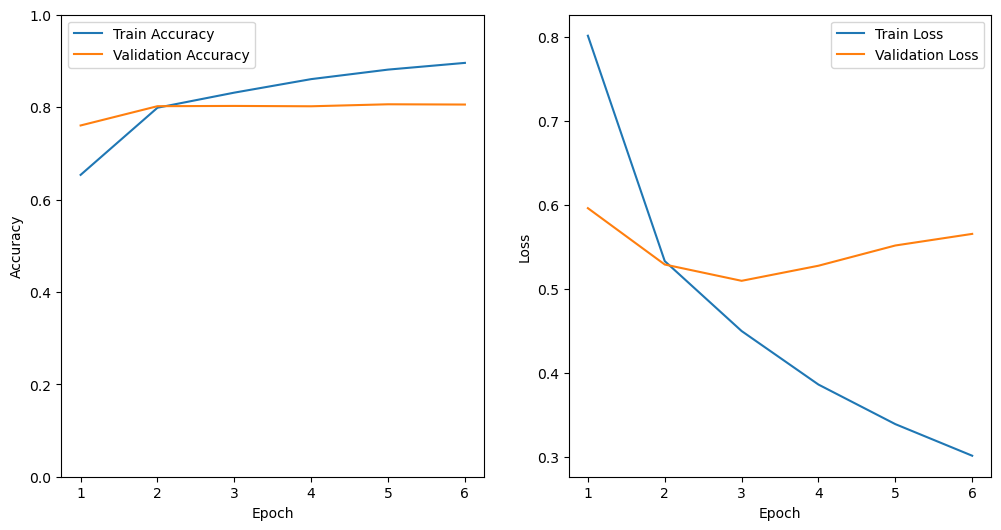

In [33]:
plot_history(history)

##### The model is exhibiting signs of overfitting, and I need to conduct hyperparameter tuning to address this issue.

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Evaluate the LSTM model <a id="Evaluate"></a> </p>

In [34]:
y_pred_lstm_prob = model.predict(X_test_padded)
y_pred_lstm      = np.argmax(y_pred_lstm_prob, axis=1)  # Get the index of the maximum probability for each sample
accuracy_lstm    = accuracy_score(y_test, y_pred_lstm)

209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step


In [35]:
print("LSTM Accuracy:", round(accuracy_lstm * 100))

LSTM Accuracy: 81


In [36]:
print(classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.55      0.39      0.45       958
           1       0.83      0.90      0.86      3169
           2       0.84      0.85      0.85      2553

    accuracy                           0.81      6680
   macro avg       0.74      0.71      0.72      6680
weighted avg       0.79      0.81      0.80      6680



# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:150%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19"> Model Testing  <a id="Model_Testing"></a> </p>

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19"> Postive review </p>

In [37]:
# Define the input sentence
input_sentence = "Absolutely loved the new menu items at the restaurant, the flavors were amazing, and the service was excellent!"

# Preprocess the input sentence
cleaned_sentence = cleanTweets(input_sentence)
removed_stopwords_sentence = remove_stopwords_spacy(cleaned_sentence)
input_sequence = tokenizer.texts_to_sequences([removed_stopwords_sentence])
padded_input_sequence = np.array(pad_sequences(input_sequence, maxlen=max_seq_length, padding='pre'))

# Make sentiment prediction
predicted_probabilities = model.predict(padded_input_sequence)
predicted_class = np.argmax(predicted_probabilities)

# Map predicted class to sentiment label
sentiment_labels = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
predicted_sentiment = sentiment_labels[predicted_class]

# Print the results
print("Predicted Sentiment:", predicted_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Sentiment: Positive


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19"> Negative review </p> 

In [38]:
# Define the input sentence
input_sentence = 'location wack   literally stop taking orders people sit parking lot like     minutes       m   don t order dinner food anymore   gone multiple times right leaving pinballz arcade sit parking lot drive line waiting wait order menu change   look mcdonald s wanted breakfast deluxe wouldn t shown       morning thank'

# Preprocess the input sentence
cleaned_sentence = cleanTweets(input_sentence)
removed_stopwords_sentence = remove_stopwords_spacy(cleaned_sentence)
input_sequence = tokenizer.texts_to_sequences([removed_stopwords_sentence])
padded_input_sequence = np.array(pad_sequences(input_sequence, maxlen=max_seq_length, padding='pre'))

# Make sentiment prediction
predicted_probabilities = model.predict(padded_input_sequence)
predicted_class = np.argmax(predicted_probabilities)

# Map predicted class to sentiment label
sentiment_labels = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
predicted_sentiment = sentiment_labels[predicted_class]

# Print the results
print("Predicted Sentiment:", predicted_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Sentiment: Negative


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Neutral review</p> 

In [43]:
# Define the input sentence
input_sentence = 'Good food but bad services'

# Preprocess the input sentence
cleaned_sentence = cleanTweets(input_sentence)
removed_stopwords_sentence = remove_stopwords_spacy(cleaned_sentence)
input_sequence = tokenizer.texts_to_sequences([removed_stopwords_sentence])
padded_input_sequence = np.array(pad_sequences(input_sequence, maxlen=max_seq_length, padding='pre'))

# Make sentiment prediction
predicted_probabilities = model.predict(padded_input_sequence)
predicted_class = np.argmax(predicted_probabilities)

# Map predicted class to sentiment label
sentiment_labels = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
predicted_sentiment = sentiment_labels[predicted_class]

# Print the results
print("Predicted Sentiment:", predicted_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Sentiment: Neutral


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19"> Conclusion <a id="conclusion"></a> </p> 

<div class="alert alert-block alert-success">
    <h3>Sentiment Analysis Model</h3>
    <br><br>
Developed a sentiment analysis model for McDonald's reviews using NLP techniques and an LSTM neural network.
</div>

<div class="alert alert-block alert-success">
    <h3>Objective Achievement</h3>
    <br><br>
Successfully achieved the goal of classifying customer sentiments as positive, negative, or neutral based on textual reviews.
</div>

<div class="alert alert-block alert-success">
    <h3>Data Preprocessing</h3>
    <br><br>
Implemented robust data preprocessing steps, including text cleaning, removal of stopwords using SpaCy, and conversion of ratings to sentiment labels.
</div>

<div class="alert alert-block alert-success">
    <h3>Model Training and Evaluation</h3>
    <br><br>
Trained the LSTM model with pre-trained word embeddings, incorporating early stopping to prevent overfitting. Achieved good accuracy and validated the model's generalization performance.
</div>

<div class="alert alert-block alert-success">
    <h3>Practical Application</h3>
    <br><br>
Demonstrated the practical application of the model with sample positive and negative reviews, showcasing its potential for real-world insights into customer satisfaction.
</div>

##### Overall, the developed solution provides McDonald's with an efficient tool for automated sentiment analysis, contributing to data-driven decision-making and enhancing the overall understanding of customer sentiments.